Import neccessary libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

Task 1: Data Preprocessing

In [14]:
data = pd.read_csv('Wholesale customers data - A.csv')
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
dtypes: int64(7)
memory usage: 24.2 KB
None
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.0

All the features other than Channel & Region clearly require normalization to be implemented.Since the max values of Channel & Region does have a slight difference of 1, we might as well normalize them as well to mitigate what little deviation they might add to the model. Furthermore, there doesn't seem to be any null values. This means we don't have to perform any imputation.

In [17]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.04111489,
        -0.58936716, -0.04356873],
       [ 1.44865163,  0.59066829, -0.39130197, ...,  0.17031835,
        -0.27013618,  0.08640684],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.0281571 ,
        -0.13753572,  0.13323164],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ...,  2.34838631,
        -0.54337975,  2.51121768],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.60251388,
        -0.41944059, -0.56977032],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.57322717,
        -0.62009417, -0.50488752]])

Task 2: Implementing K-means & Hierarchical clustering

K-means clustering

Determine the optimal number of clusters with the help of mean-silhouette graph

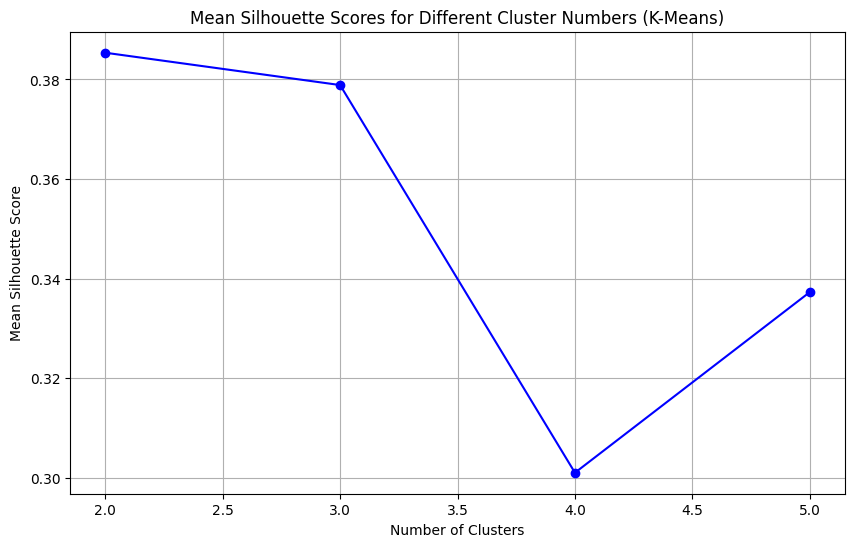

In [18]:
meanSilhouette_scores = []
# test for cluster numbers 2 to 5
probable_clusters = range(2,6)

for cluster in probable_clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    mean_silhouette = silhouette_score(data_scaled, cluster_labels)
    meanSilhouette_scores.append(mean_silhouette)

# Plotting Mean Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(probable_clusters, meanSilhouette_scores, marker='o', color='b')
plt.title('Mean Silhouette Scores for Different Cluster Numbers (K-Means)')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.grid(True)
plt.show()

Therefore, the number of optimal clusters can be concluded as two for KMean Clustering

Find number of clusters for Hierarchical clustering

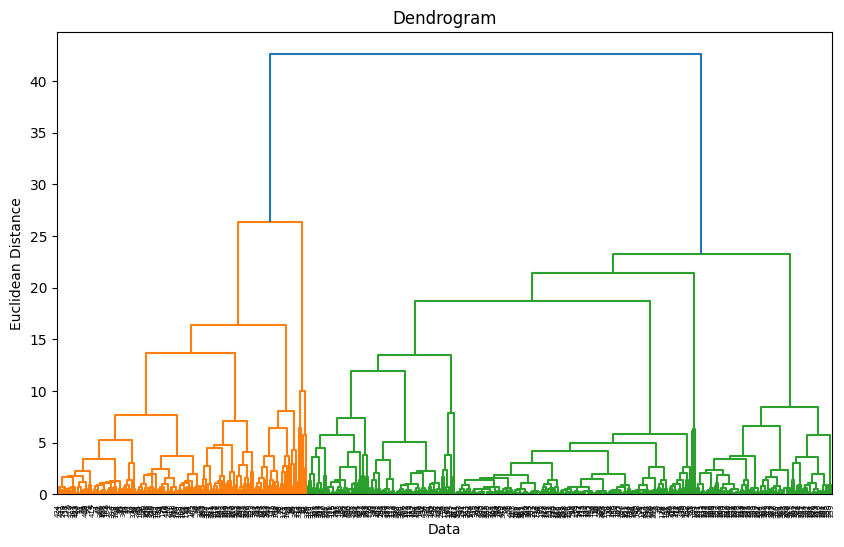

In [25]:
plt.figure(figsize=(10, 6))
linked = linkage(data_scaled, method='ward')  # Using Ward's method for hierarchical clustering
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Data')
plt.ylabel('Euclidean Distance')
plt.show()

Based on the abovr diagram, the optimal number of clusters seem to be two.